In [1]:
from math import log10

import numpy as np
from astropy.io import fits
from astropy.table import Table
from matplotlib.colors import LogNorm
import scipy
from scipy import stats

import matplotlib.pyplot as plt

In [2]:
hdul = fits.open("Data/HI-MaNGA_with_MA.fits")
dataTable = Table(hdul[1].data)
dataTable # to see if it worked, we will print out the table

PLATEIFU_1,MANGAID,OBJRA,OBJDEC,LOGMSTARS,SINI,VOPT,SESSION,EXP,RMS,LOGHILIM200KMS,PEAK,SNR,FHI,EFHI,LOGMHI,VHI,EV,WM50,WP50,WP20,W2P50,WF50,DW,PR,PL,AR,BR,AL,BL,NEGDET,BLSTRUCT,conflag,conf_prob,plateifu_2,ang_stellar,ang_stellar_err,ang_ha,ang_ha_err,GroupID,GroupSize
str11,str9,float64,float64,float64,float64,float32,str111,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float64,str12,float32,float32,float32,float32,int32,int32
10001-12701,1-48157,133.371090612,57.5984251446,9.428999281013443,0.927642710084122,11754.1,AGBT17A_012_19,896.8291,1.4207177,-999.0,0.0137383435,8.670002,3.313165,0.14617112,10.35004,11955.675,47.163033,432.4681,303.13943,434.7268,307.13962,287.3401,6.6275935,11.448619,7.819415,8.402823,0.02141115,56.474014,-0.34800306,0,0,1,0.8158912066758643,,nan,nan,nan,nan,-2147483648,-2147483648
10001-12702,1-48188,133.685669869,57.4802503218,9.666748170493861,0.8179359455005117,12234.8,AGBT17A_012_21,896.8445,1.4478949,-999.0,0.0053441967,2.6910114,0.542418,0.10295577,9.583724,12238.846,5.616053,229.21356,224.51225,230.25624,224.73874,223.7095,3.6541126,4.3635135,4.453497,22.229292,0.17453198,32.058037,-0.25722012,0,0,0,0.0,,nan,nan,nan,nan,-2147483648,-2147483648
10001-12703,1-55648,136.017159969,57.0923291779,9.974958652419431,0.9448822101276089,13853.2,AGBT17A_012_21,896.9,1.43424,-999.0,0.0062160227,4.33402,0.66,0.09151866,9.775859,13859.35,30.7268,390.53607,350.6874,388.82513,358.11423,362.01404,3.8883114,4.0,5.18,25.63,0.13,11.34,-0.05,0,0,0,0.0,,nan,nan,nan,nan,-2147483648,-2147483648
10001-12704,1-55616,133.989966869,57.6779676669,9.625145699270158,0.9973518809685926,4233.5,AGBT17A_012_19,897.2,1.63068,-999.0,0.011355257,6.96351,2.028,0.09155911,9.239542,4232.86,4.81335,289.92322,295.73117,289.3217,298.70914,292.1616,5.3867235,9.46,7.03,23.03,0.13,48.09,-0.3,0,0,0,0.0,,nan,nan,nan,nan,-2147483648,-2147483648
10001-12705,1-55784,136.75137451,57.4514369241,9.984605164340124,0.8582810369159054,13860.9,AGBT17A_012_21,896.9,1.2722402,-999.0,0.00589785,4.6358,0.81600004,0.08192676,9.8647175,13809.01,58.0585,387.08972,310.01324,387.15662,311.63812,368.958,4.0274525,3.7,4.91,2.04,-999.0,75.33,-0.38,0,0,0,0.0,,nan,nan,nan,nan,-2147483648,-2147483648
10001-1901,1-55567,133.330028009,57.0411553708,9.13950127473591,0.8639045486216899,7719.6,AGBT17A_012_19,896.9762,1.5561128,8.945167,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0,0,0,0.0,,nan,nan,nan,nan,-2147483648,-2147483648
10001-1902,1-48201,134.193923352,56.7867469988,10.05560383069523,0.5538396901353395,7612.0,AGBT17A_012_19-AGBT17A_012_21,946.79913,1.332848,8.865786,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0,0,0,0.0,,nan,nan,nan,nan,-2147483648,-2147483648
10001-3701,1-48111,132.465646765,57.1437279024,9.712998848471644,0.42768481402593606,11817.5,AGBT17A_012_19,896.7699,1.3519847,9.251231,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0,0,0,0.0,,nan,nan,nan,nan,-2147483648,-2147483648
10001-3702,1-48136,132.912768243,57.1074235568,9.85250134185775,0.3220751080079571,7676.6,AGBT17A_012_19,847.1916,1.5806576,8.94714,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0,0,0,0.0,10001-3702,318.5,12.25,148.0,17.5,-2147483648,-2147483648


In [3]:
'''
Let's get a list of all of the columns, since it may be hard to refer to them just from looking at the cell output:
'''
columnNames = []
for column in dataTable.columns:
    columnNames.append(column)
print(columnNames)

['PLATEIFU_1', 'MANGAID', 'OBJRA', 'OBJDEC', 'LOGMSTARS', 'SINI', 'VOPT', 'SESSION', 'EXP', 'RMS', 'LOGHILIM200KMS', 'PEAK', 'SNR', 'FHI', 'EFHI', 'LOGMHI', 'VHI', 'EV', 'WM50', 'WP50', 'WP20', 'W2P50', 'WF50', 'DW', 'PR', 'PL', 'AR', 'BR', 'AL', 'BL', 'NEGDET', 'BLSTRUCT', 'conflag', 'conf_prob', 'plateifu_2', 'ang_stellar', 'ang_stellar_err', 'ang_ha', 'ang_ha_err', 'GroupID', 'GroupSize']


Lets first visualize the data by plotting all galaxies' positions, just to make sure everything is going smoothly so far. As we saw above, there are 6938 galaxies in the file now, though not all of them have data for all of their parameters.

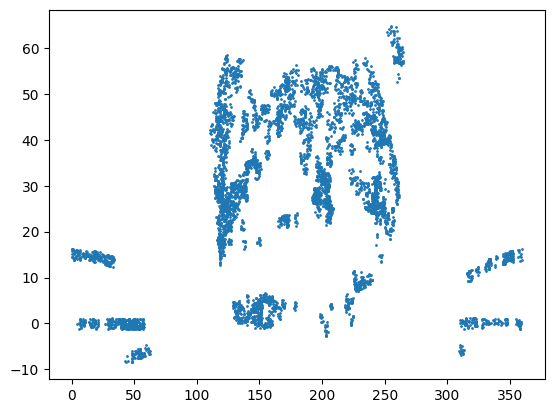

In [4]:
plt.scatter(dataTable['OBJRA'], dataTable['OBJDEC'], s=1);

Now we can start looking at the relevant data; the position angles of the gas and stellar disks, and the HI deficiencies of the galaxies. First, lets just plot the galaxies' masses of gas as a function of stellar mass.

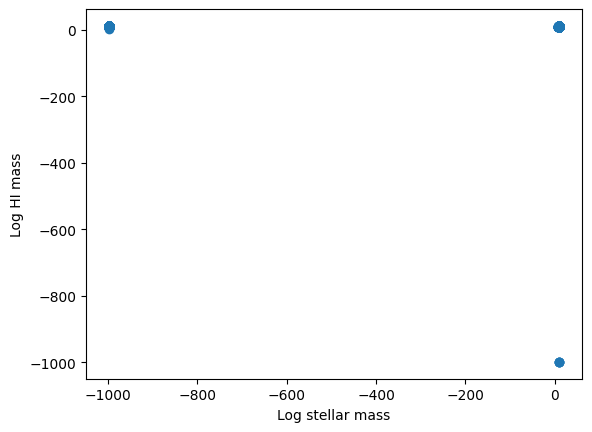

In [5]:
plt.scatter(dataTable['LOGMHI'], dataTable['LOGMSTARS'])
plt.xlabel('Log stellar mass')
plt.ylabel('Log HI mass');

Hmm... it looks like we have outliers. Non-detections are recorded as having values of -999, so we need to make sure we select the right data points. Let's make arrays that select for the useful data.

In [6]:
allGalStellarMass = []
allGalGasMass = []
for gal in dataTable:
    if gal['LOGMSTARS'] > 0 and max(gal['LOGMHI'], gal['LOGHILIM200KMS']) > 0:
        allGalStellarMass.append(gal['LOGMSTARS'])
        allGalGasMass.append(max(gal['LOGMHI'], gal['LOGHILIM200KMS']))

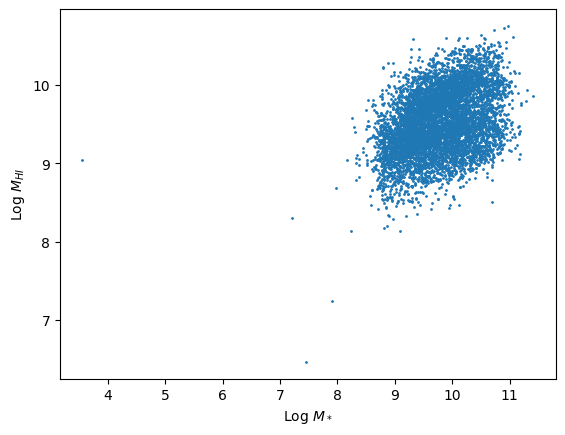

In [7]:
plt.scatter(allGalStellarMass, allGalGasMass, s=1)
plt.xlabel('Log $M_*$')
plt.ylabel('Log $M_{HI}$');

Good! We've removed our non-detection outliers (though we've just assumed that our non-detection upper limits for HI mass are true values, which isn't quite right. We'll have to account for that later with statistical methods, i.e. survival anlysis). Now, let's revise this data to represent mass fraction, the log of the ratio of gas mass to stellar mass

In [8]:
allGalMassFraction = [0]*len(allGalStellarMass)
for i in range(len(allGalStellarMass)):
    allGalMassFraction[i] = allGalGasMass[i] - allGalStellarMass[i]

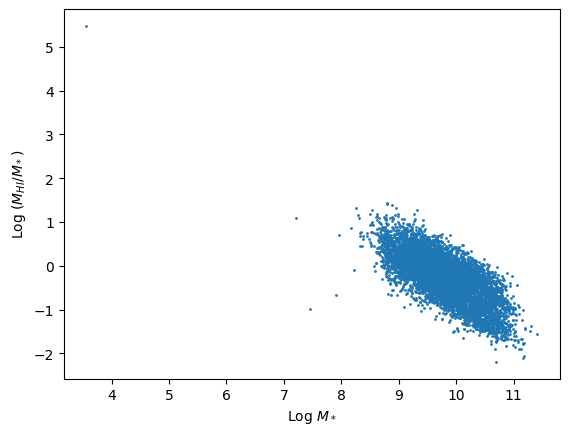

In [9]:
plt.xlabel('Log $M_*$')
plt.ylabel('Log $(M_{HI}/M_*)$');
plt.scatter(allGalStellarMass, allGalMassFraction, s=1);

We'll also change the bounds of the plot to exclude the one point far from the rest of the data (in the top left corner), which will allow us to improve the readability of the plot without skewing the data (though we should keep in mind that some data is not being shown).

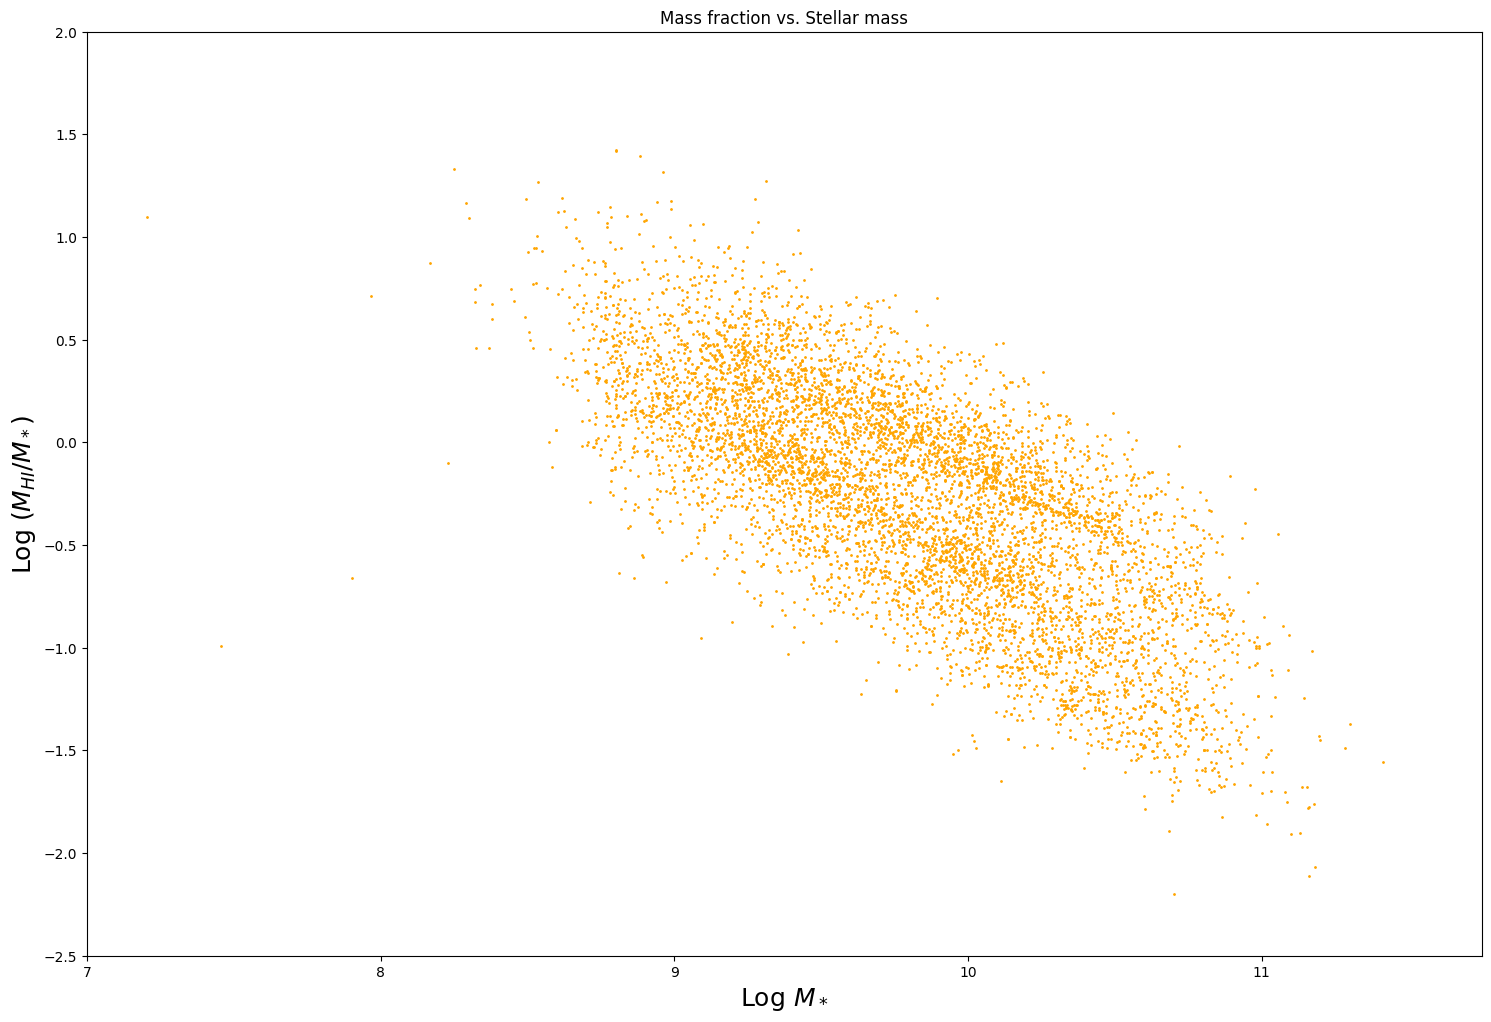

In [10]:
plt.figure(figsize=(18, 12))
plt.xlim(7, 11.75)
plt.ylim(-2.5, 2)
plt.xlabel('Log $M_*$', fontsize=18)
plt.ylabel('Log $(M_{HI}/M_*)$', fontsize=18);
plt.title('Mass fraction vs. Stellar mass')
plt.scatter(allGalStellarMass, allGalMassFraction, s=1, color='orange');

Our data is becoming quite readable, and we have shown a general trend in galaxies that galaxies with greater stellar masses have lower mass fractions. What we want, however, is to compare the mass fractions of the well-aligned galaxies (that is, small differences in position angles between their discs) to the misaligned galaxies (larger differences in position angles). Therefore, lets make arrays for these more specific categories:

In [11]:
alignedMStars = []
alignedMFrac = []
MAMStars = [] #MA meaning 'misaligned'
MAMFrac =[]
for gal in dataTable:
    if gal['LOGMSTARS'] > 0 and max(gal['LOGMHI'], gal['LOGHILIM200KMS']) > 0 and gal['plateifu_2'] == '': # the misaligned galaxies will have values for this column, which was taken from the fits image of just misaliged galaxies, while the aligned galaxies will not
        alignedMStars.append(gal['LOGMSTARS'])
        alignedMFrac.append(max(gal['LOGMHI'], gal['LOGHILIM200KMS']) - gal['LOGMSTARS'])
    if gal['LOGMSTARS'] > 0 and max(gal['LOGMHI'], gal['LOGHILIM200KMS']) > 0 and gal['plateifu_2'] != '':
        MAMStars.append(gal['LOGMSTARS'])
        MAMFrac.append(max(gal['LOGMHI'], gal['LOGHILIM200KMS']) - gal['LOGMSTARS'])

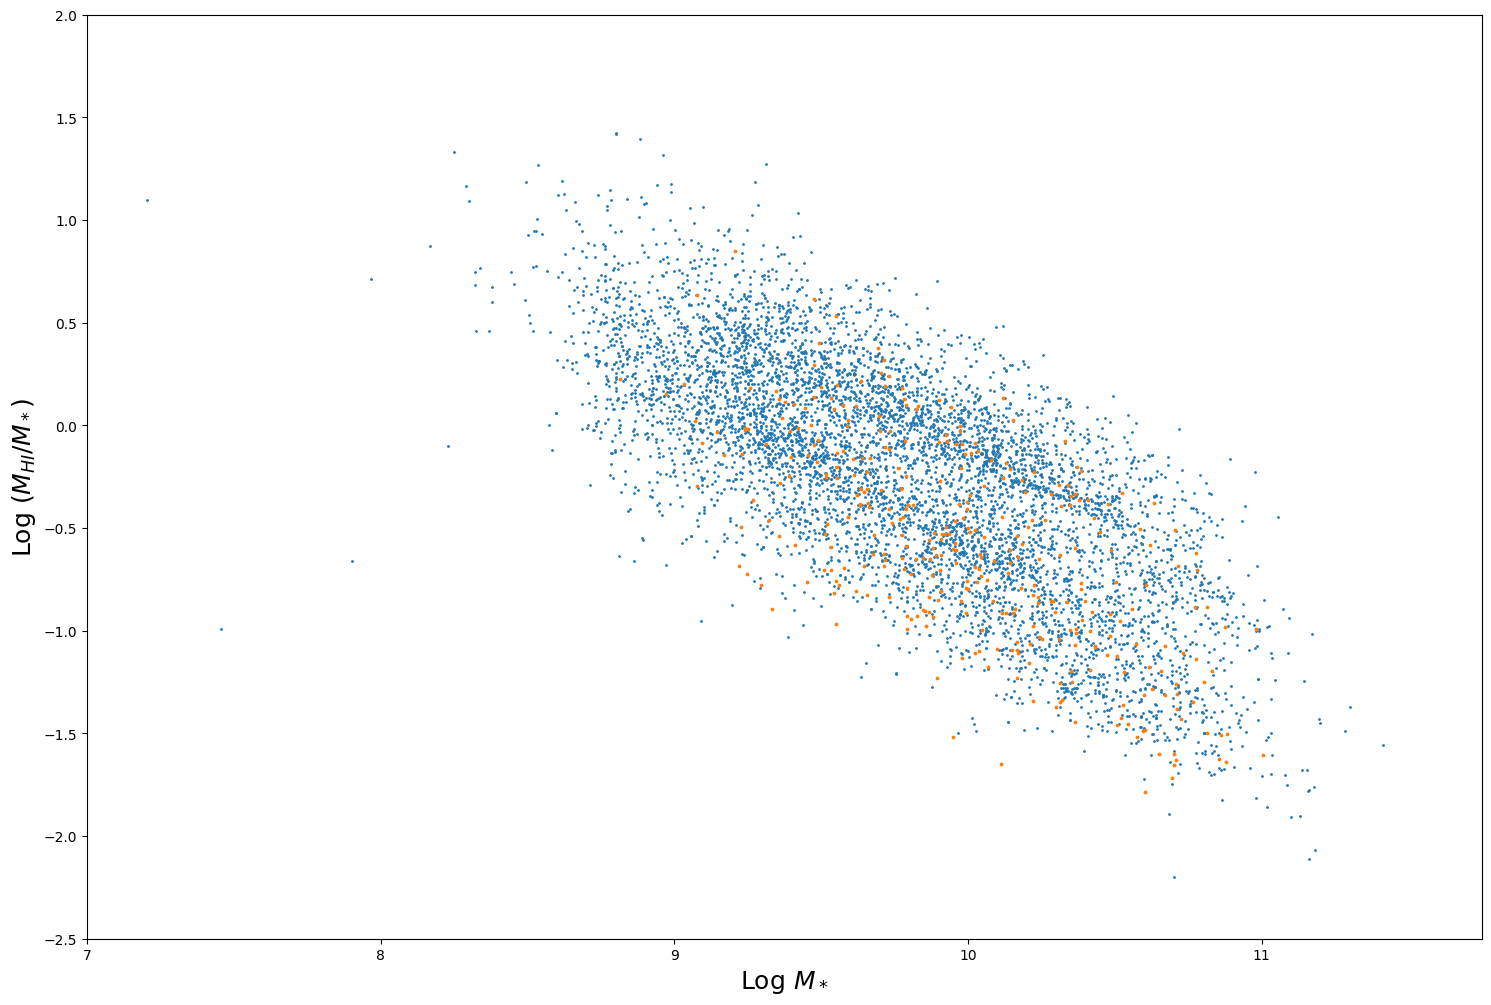

In [12]:
plt.figure(figsize=(18, 12))
plt.xlim(7, 11.75)
plt.ylim(-2.5, 2)
plt.xlabel('Log $M_*$', fontsize=18)
plt.ylabel('Log $(M_{HI}/M_*)$', fontsize=18);
plt.scatter(alignedMStars, alignedMFrac, s=1);
plt.scatter(MAMStars, MAMFrac, s=3);

Great! We've picked out the points that correspond to misaligned galaxies from those corresponding to well-aligned galaxies. To make this analysis more qualitative, let's fit trends to each set of data.

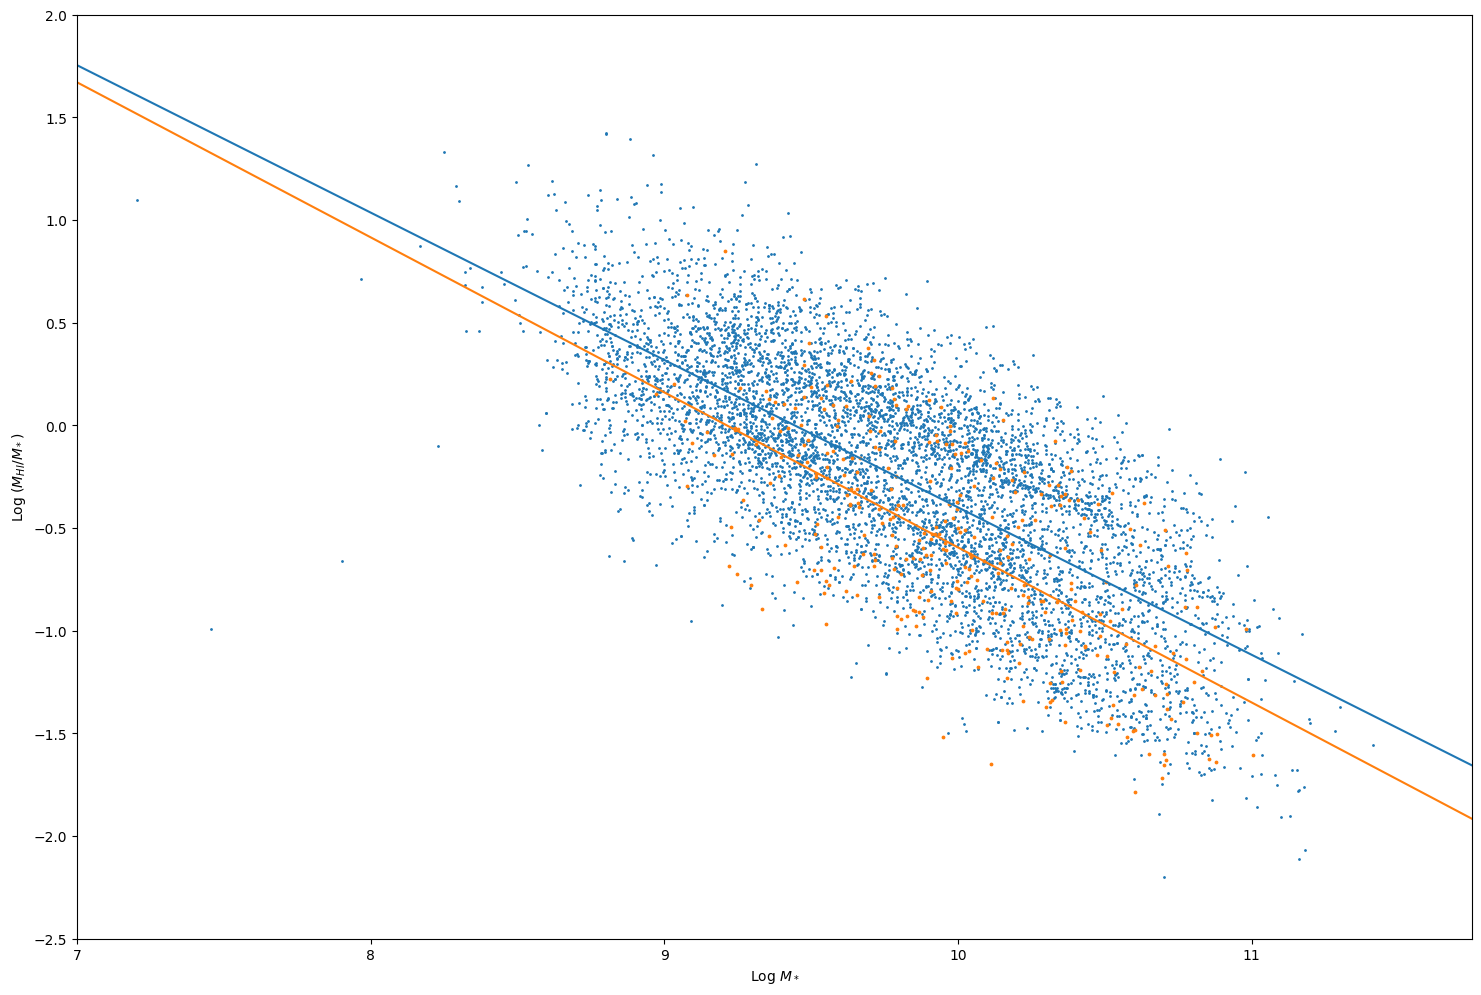

In [13]:
WAlinFit = np.polyfit(alignedMStars, alignedMFrac, 1)
MAlinFit = np.polyfit(MAMStars, MAMFrac, 1);
WAlinFit, MAlinFit
alignedAr = [[6, 13],[6*WAlinFit[0] + WAlinFit[1], 13*WAlinFit[0] + WAlinFit[1]]]
MAAr = [[6, 13],[6*MAlinFit[0] + MAlinFit[1], 13*MAlinFit[0] + MAlinFit[1]]]

plt.figure(figsize=(18, 12))
plt.xlim(7, 11.75)
plt.ylim(-2.5, 2)
plt.xlabel('Log $M_*$')
plt.ylabel('Log $(M_{HI}/M_*)$');
plt.scatter(alignedMStars, alignedMFrac, s=1);
plt.scatter(MAMStars, MAMFrac, s=3);
plt.plot(alignedAr[0], alignedAr[1])
plt.plot(MAAr[0], MAAr[1]);

Interesting! It seems that misaligned galaxies actually have *less* gas than their well-aligned counterparts, which is not necessarily what we expect. Usually misalignment results from a recent accretion of new gas into the galaxy, gas which preserves its angular momentum therefore creating a misaligned gas disc. This suggests that the processes at play are more complicated than they appear, but we can make the trends more precise. Let's bin the data into segments. This binning code is modified from Patrick Wang (Haverford College '27).

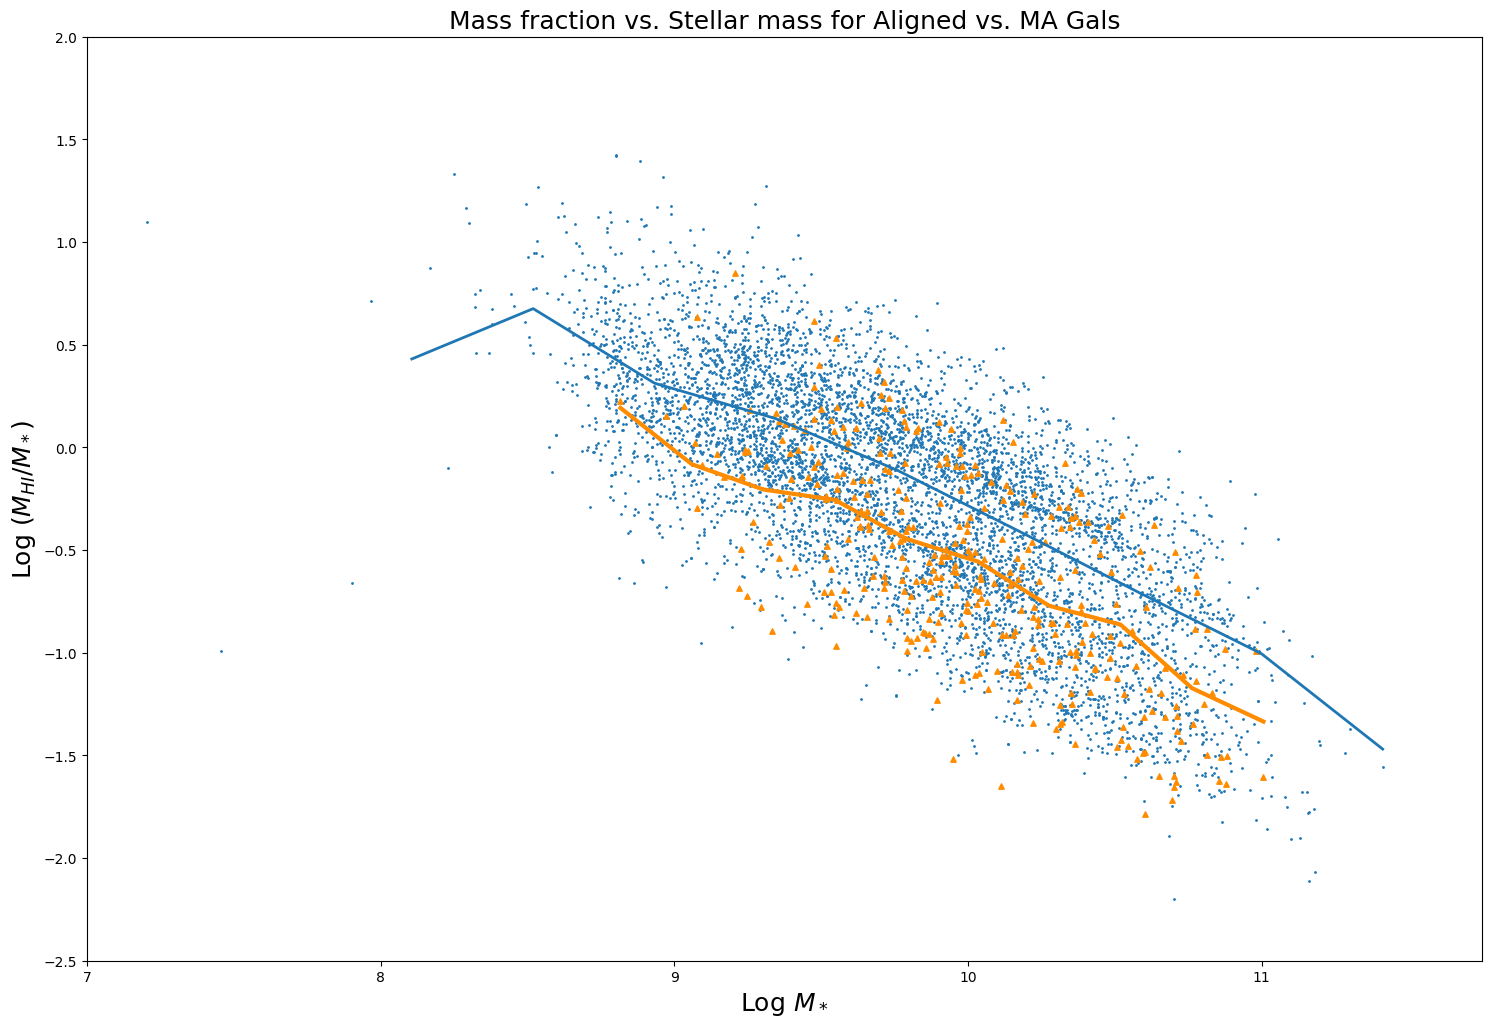

In [14]:
alignedBin = scipy.stats.binned_statistic(alignedMStars, alignedMFrac, 'mean', bins=20)
alignedXs = np.linspace(min(alignedMStars), max(alignedMStars), 20)

MABin = scipy.stats.binned_statistic(MAMStars, MAMFrac, 'mean', bins=10)
MAXs = np.linspace(min(MAMStars), max(MAMStars), 10)

plt.figure(figsize=(18, 12))
plt.xlim(7, 11.75)
plt.ylim(-2.5, 2)
plt.xlabel('Log $M_*$', fontsize=18)
plt.ylabel('Log $(M_{HI}/M_*)$', fontsize=18);
plt.title('Mass fraction vs. Stellar mass for Aligned vs. MA Gals', fontsize=18)
plt.scatter(alignedMStars, alignedMFrac, s=1, color = 'tab:blue');
plt.scatter(MAMStars, MAMFrac, s=15, color = 'darkorange', marker='^');

plt.plot(alignedXs, alignedBin[0], lw=2, color = 'tab:blue')
plt.plot(MAXs, MABin[0], lw=3, color = 'darkorange');

We still haven't analyzed any of the upper limits with proper statistical methods, but by binning the data we can show a more robust difference between the two data sets than with a simple linear fit. We've confirmed that there is indeed a correlation between galaxies having position angle misalignment, and having a greater HI deficiency than an aligned galaxy with the same stellar mass.

The last thing we'll do with this data before staistically analyzing the upper limits with survival anlysis techniques is to divide the misaligned galaxies into various degrees of misalignment. Let's first make a plot of frequency vs misalignment in order to decide what cutoff of misalignment we will consider to be "counter-rotating"

In [15]:
misalignedHA = []
misalignedStel = []
for gal in dataTable:
    if str(gal['ang_ha']) != 'nan':
        if gal['ang_ha'] > 180:
            misalignedHA.append(360 - gal['ang_ha'])
        else:
            misalignedHA.append(gal['ang_ha'])
        if gal['ang_stellar'] > 180:
            misalignedStel.append(360 - gal['ang_stellar'])
        else:
            misalignedStel.append(gal['ang_stellar'])

misalignedDelPA = []
for i in range(len(misalignedHA)):
    misalignedDelPA.append(abs(misalignedHA[i] - misalignedStel[i]))

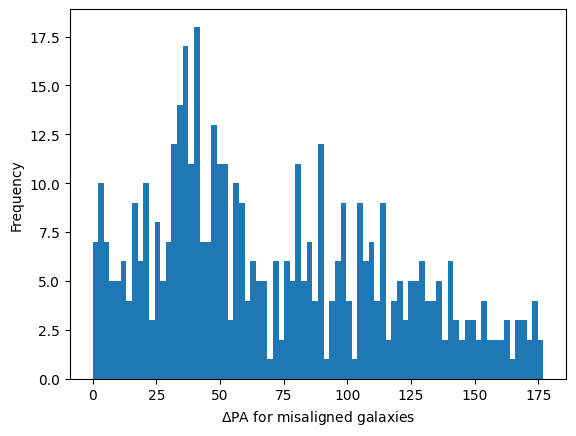

In [16]:
plt.figure()
plt.xlabel('$\Delta$PA for misaligned galaxies')
plt.ylabel('Frequency')
plt.hist(misalignedDelPA, bins=80);

There's no abundantly clear division. For now, let's just take all the galaxies with a misalignment of at least 90 degrees as 'counter-rotating,' and plot that data with binned averages.

In [17]:
counterMStel = []
counterFrac = []

for gal in dataTable:
    angHa = 0
    angStel = 0
    if str(gal['ang_ha']) != 'nan':
        if gal['ang_ha'] > 180:
            angHa = 360 - gal['ang_ha']
        else:
            angHa = gal['ang_ha']
        if gal['ang_stellar'] > 180:
            angStel = 360 - gal['ang_stellar']
        else:
            angStel = gal['ang_stellar']
    if abs(angHa - angStel) >= 90 and str(gal['LOGMSTARS']) != 'nan':
        counterMStel.append(gal['LOGMSTARS'])
        counterFrac.append(max(gal['LOGMHI'], gal['LOGHILIM200KMS']) - gal['LOGMSTARS'])

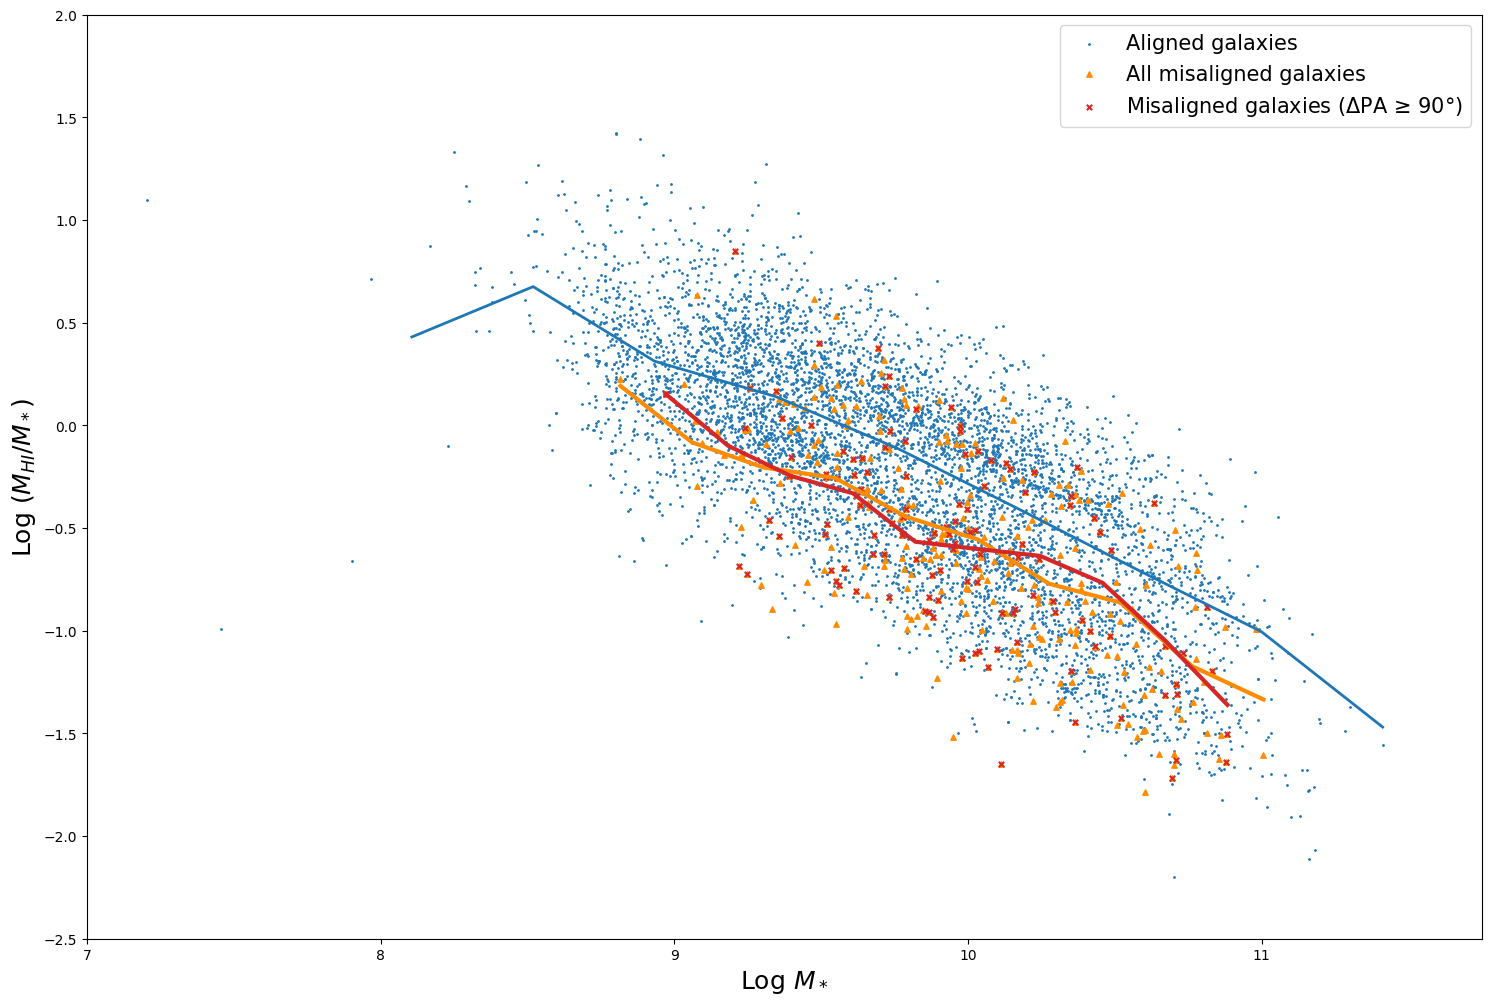

In [18]:
counterBin = scipy.stats.binned_statistic(counterMStel, counterFrac, 'mean', bins=10)
counterXs = np.linspace(min(counterMStel), max(counterMStel), 10)

plt.figure(figsize=(18, 12))
plt.xlim(7, 11.75)
plt.ylim(-2.5, 2)
plt.xlabel('Log $M_*$', fontsize=18)
plt.ylabel('Log $(M_{HI}/M_*)$', fontsize=18);
plt.scatter(alignedMStars, alignedMFrac, s=1, color = 'tab:blue', label='Aligned galaxies');
plt.scatter(MAMStars, MAMFrac, s=15, color = 'darkorange', marker='^', label = 'All misaligned galaxies');
plt.scatter(counterMStel, counterFrac, s = 15, color = 'tab:red', marker = 'x', label = 'Misaligned galaxies ($\Delta$PA ≥ 90$\degree$)');

plt.plot(alignedXs, alignedBin[0], lw=2, color = 'tab:blue')
plt.plot(MAXs, MABin[0], lw=3, color = 'darkorange');
plt.plot(counterXs, counterBin[0], lw = 3, color='tab:red')
plt.legend(fontsize = 15);
plt.savefig('mFrac_vs_mStel_binned.png')

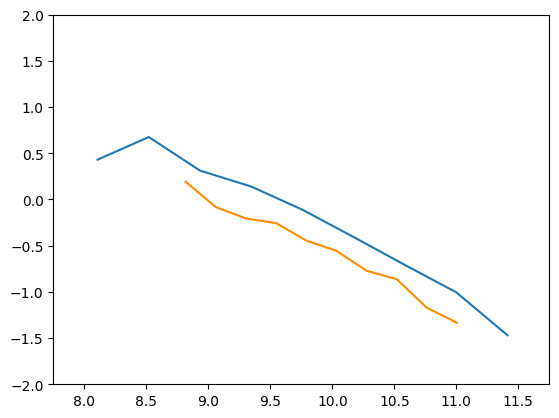

In [19]:
plt.xlim(7.75, 11.75)
plt.ylim(-2, 2)
plt.plot(alignedXs, alignedBin[0], color = 'tab:blue')
plt.plot(MAXs, MABin[0], color = 'darkorange');

Interestingly, we see that the group of all misaligned galaxies and the counter-rotating galaxies have very similar HI deficiencies, rather than the counter rotators having a more pronounced HI deficiency than other, less misaligned galaxies. However, we have still established a clear trend of misaligned galaxies having higher HI deficiencies than their well-aligned counterparts at their given stellar masses.

To quantify this deficiency, we can plot the difference between the HI deficiencies of the aligned galaxies and the HI deficiencies of the mis-aligned galaxies. Seeing that the counter-rotating galaxies have fairly similar trends to the mis-aligned galaxies as a whole, we will use the latter set, since it gives us more data points with which to work.

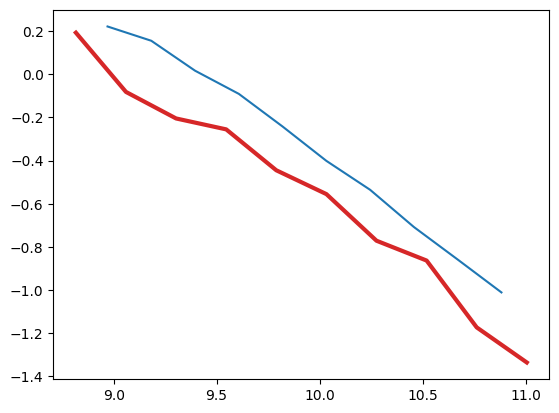

In [20]:
MABinDiff = [0]*10 # array of binned differences in HI deficiencies (on average, how deficient are each stellar mass's misaligned galaxies compared to that stellar mass's well-aligned galaxies)
limitedBin = []
limitedXs = []

for gal in dataTable:
    if max(counterXs) >= gal['LOGMSTARS'] >= min(counterXs) and str(gal['plateifu_2']) == '' and (gal['LOGMHI'] > 0 or gal['LOGHILIM200KMS'] > 0):
        limitedBin.append(max(gal['LOGMHI'], gal['LOGHILIM200KMS']) - gal['LOGMSTARS'])
        limitedXs.append(gal['LOGMSTARS'])

limitedAlignedBin = scipy.stats.binned_statistic(limitedXs, limitedBin, 'mean', bins=10)

plt.plot(np.linspace(min(limitedXs), max(limitedXs), 10), limitedAlignedBin[0], color = 'tab:blue')

for i in range(10):
    MABinDiff[i] =  limitedAlignedBin[0][i] - MABin[0][i]

#plt.plot(MAXs, MABinDiff);
plt.plot(MAXs, MABin[0], lw = 3, color='tab:red');

And we can normalize this plot, taking the difference between the two heights

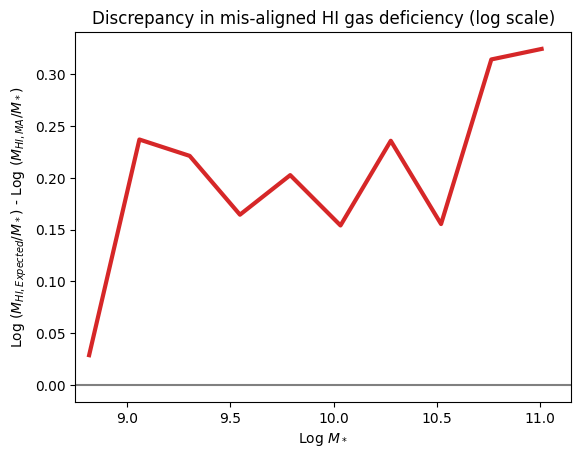

In [21]:
plt.xlim(8.75, 11.15)
plt.plot(MAXs, MABinDiff, lw = 3, color='tab:red');
plt.plot([5, 15], [0, 0], color = 'grey');
plt.title('Discrepancy in mis-aligned HI gas deficiency (log scale)')
plt.xlabel('Log $M_*$')
plt.ylabel('Log $(M_{HI, Expected}/M_*)$ - Log $(M_{HI, MA}/M_*)$');

**\*Check this math\*:** We can convert this log scale to percentages to understand the significance of this data:

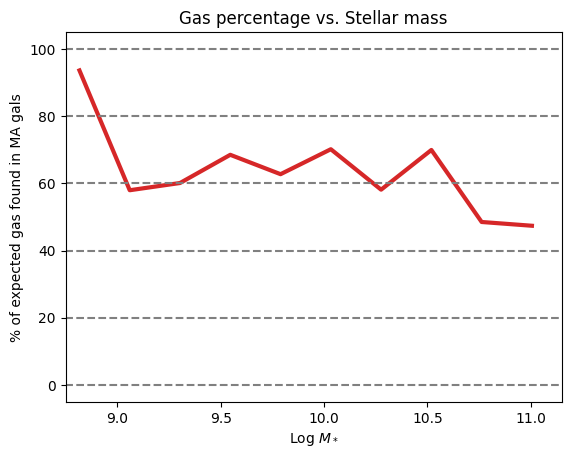

In [22]:
plt.xlim(8.75, 11.15)

MABinDiffPerc = [0]*10
for i in range(10):
    MABinDiffPerc[i] = 10**(-MABinDiff[i]) * 100

plt.xlabel('Log $M_*$')
plt.ylabel('% of expected gas found in MA gals')
plt.title('Gas percentage vs. Stellar mass')
plt.plot(MAXs, MABinDiffPerc, lw = 3, color='tab:red');


plt.plot([5, 15], [0, 0], '--', color = 'grey');
plt.plot([5,15], [100, 100], '--', color = 'grey');
plt.plot([5,15], [80, 80], '--', color = 'grey');
plt.plot([5,15], [60, 60], '--', color = 'grey');
plt.plot([5,15], [40, 40], '--', color = 'grey');
plt.plot([5,15], [20, 20], '--', color = 'grey');


From this plot, we can see that misaligned galaxies can have 60-70% of the HI gas as we expect from a well-aligned galaxy at their given stellar mass, which is an extremely large difference.

To take binned *medians*, with error bars, we will include upper limits as accepted values. The following code is again modified from Patrick Wang (HC '27)


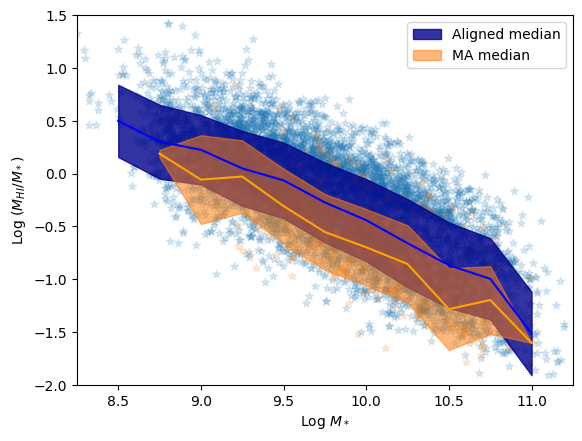

In [23]:
plt.xlim(8, 11.5)
plt.ylim(-2.5, 2)

Alignedmedians, Alignededgesmedian, Alignednummedian = scipy.stats.binned_statistic(alignedMStars,alignedMFrac,'median',bins=np.arange(8.5,11.5,0.25))
Alignedstds, Alignededgesstd, Alignednumstd=scipy.stats.binned_statistic(alignedMStars,alignedMFrac,'std',bins=np.arange(8.5,11.5,0.25))

MAmedians, MAedgesmedian, MAnummedian = scipy.stats.binned_statistic(MAMStars, MAMFrac, statistic = 'median', bins=np.arange(8.5,11.5,0.25))
MAstds,MAedgesstd,MAnumstd=scipy.stats.binned_statistic(MAMStars,MAMFrac, statistic = 'std', bins=np.arange(8.5,11.5,0.25))

plt.scatter(alignedMStars, alignedMFrac, marker = '*', color='tab:blue', alpha=0.15)
plt.scatter(MAMStars, MAMFrac, marker = '*', color='tab:orange', alpha=0.15)

#plotting binned data by using the edges of the bins
plt.plot((Alignededgesmedian)[:-1], Alignedmedians, ls='-', alpha=1, color='blue')
plt.plot((MAedgesmedian)[:-1], MAmedians, ls='-', alpha=1, color='orange')

#highlighting the standard deviation of this binned data
plt.fill_between(Alignededgesmedian[:-1],Alignedmedians-Alignedstds,Alignedmedians+Alignedstds,alpha=.8, color='darkblue', label='Aligned median')
plt.fill_between(MAedgesmedian[:-1],MAmedians-MAstds,MAmedians+MAstds,alpha=.55, color='tab:orange', label='MA median');
plt.legend()
plt.xlabel('Log $M_*$')
plt.ylabel('Log $(M_{HI}/M_*)$');
plt.ylim(-2, 1.5)
plt.xlim(8.25, 11.25)
plt.show()

In [24]:
medianMStel = []
medianMFracDiff = []
adjustedDiff = []

for i in range(10):
    if MAmedians[i] > -100:
        medianMStel.append(Alignededgesmedian[:-1][i])
        medianMFracDiff.append(Alignedmedians[i] - MAmedians[i])
        adjustedDiff.append(100 * 10**(-1 * (Alignedmedians[i] - MAmedians[i])))


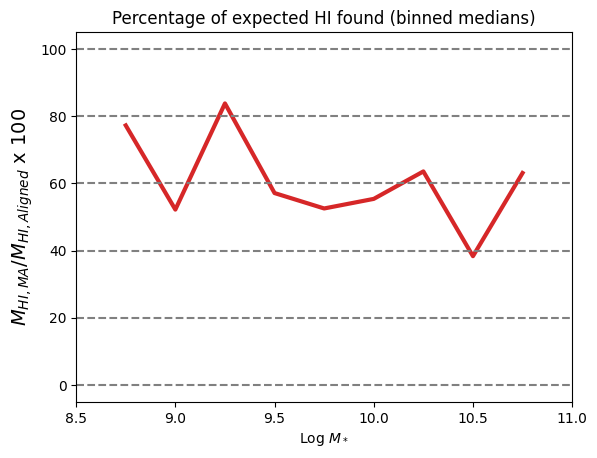

In [25]:
plt.plot(medianMStel, adjustedDiff, lw = 3, color='tab:red')
plt.plot([5, 15], [0, 0], '--', color = 'grey');
plt.plot([5,15], [100, 100], '--', color = 'grey');
plt.plot([5,15], [80, 80], '--', color = 'grey');
plt.plot([5,15], [60, 60], '--', color = 'grey');
plt.plot([5,15], [40, 40], '--', color = 'grey');
plt.plot([5,15], [20, 20], '--', color = 'grey');
plt.xlim(8.5, 11)
plt.title('Percentage of expected HI found (binned medians)')
plt.xlabel('Log $M_*$')
plt.ylabel('$M_{HI, MA}/M_{HI, Aligned}$ x 100', fontsize=14);

**Survival Analysis:** In order to do survival analysis, we'll need to first create new data sets corresponding to the detections vs upper limis (non-detections). The detections will have entries in the 'LOGMHI' column of the fits image (other than 'NaN' or -999), while the non-detections will have entires in the 'LOGLIMHI200KMS' column (other than 'NaN' or -999). Also, we've just shown a distinct but fluctuating HI deficiency in misaligned galaxies with binned data, but for purposes of survival analysis, we'll be using a simple linear fit (at least for now).

In [26]:
from survival_analysis import setup, ats_fit, kaplan_meier

In [27]:
WADetectionStel = []
WADetectionFrac = []
WALimStel = []
WALimFrac = []

MADetectionStel = []
MADetectionFrac = []
MALimStel = []
MALimFrac = []

for gal in dataTable:
    if gal['LOGMSTARS'] > 0 and gal['LOGMHI'] > 0: # Well-defined gas mass
        if gal['plateifu_2'] != '': # Misaligned, so has an entry from the misaligned galaxy fits file
            MADetectionStel.append(gal['LOGMSTARS'])
            MADetectionFrac.append(gal['LOGMHI'] - gal['LOGMSTARS'])
        elif gal['plateifu_2'] == '': # Aligned, so does not
            WADetectionStel.append(gal['LOGMSTARS'])
            WADetectionFrac.append(gal['LOGMHI'] - gal['LOGMSTARS'])
    elif gal['LOGMSTARS'] > 0 and gal['LOGHILIM200KMS'] > 0: # Upper limit/non-detection
        if gal['plateifu_2'] != '': # Misaligned, so has an entry from the misaligned galaxy fits file
            MALimStel.append(gal['LOGMSTARS'])
            MALimFrac.append(gal['LOGHILIM200KMS'] - gal['LOGMSTARS'])
        elif gal['plateifu_2'] == '': # Aligned, so does not
            WALimStel.append(gal['LOGMSTARS'])
            WALimFrac.append(gal['LOGHILIM200KMS'] - gal['LOGMSTARS'])

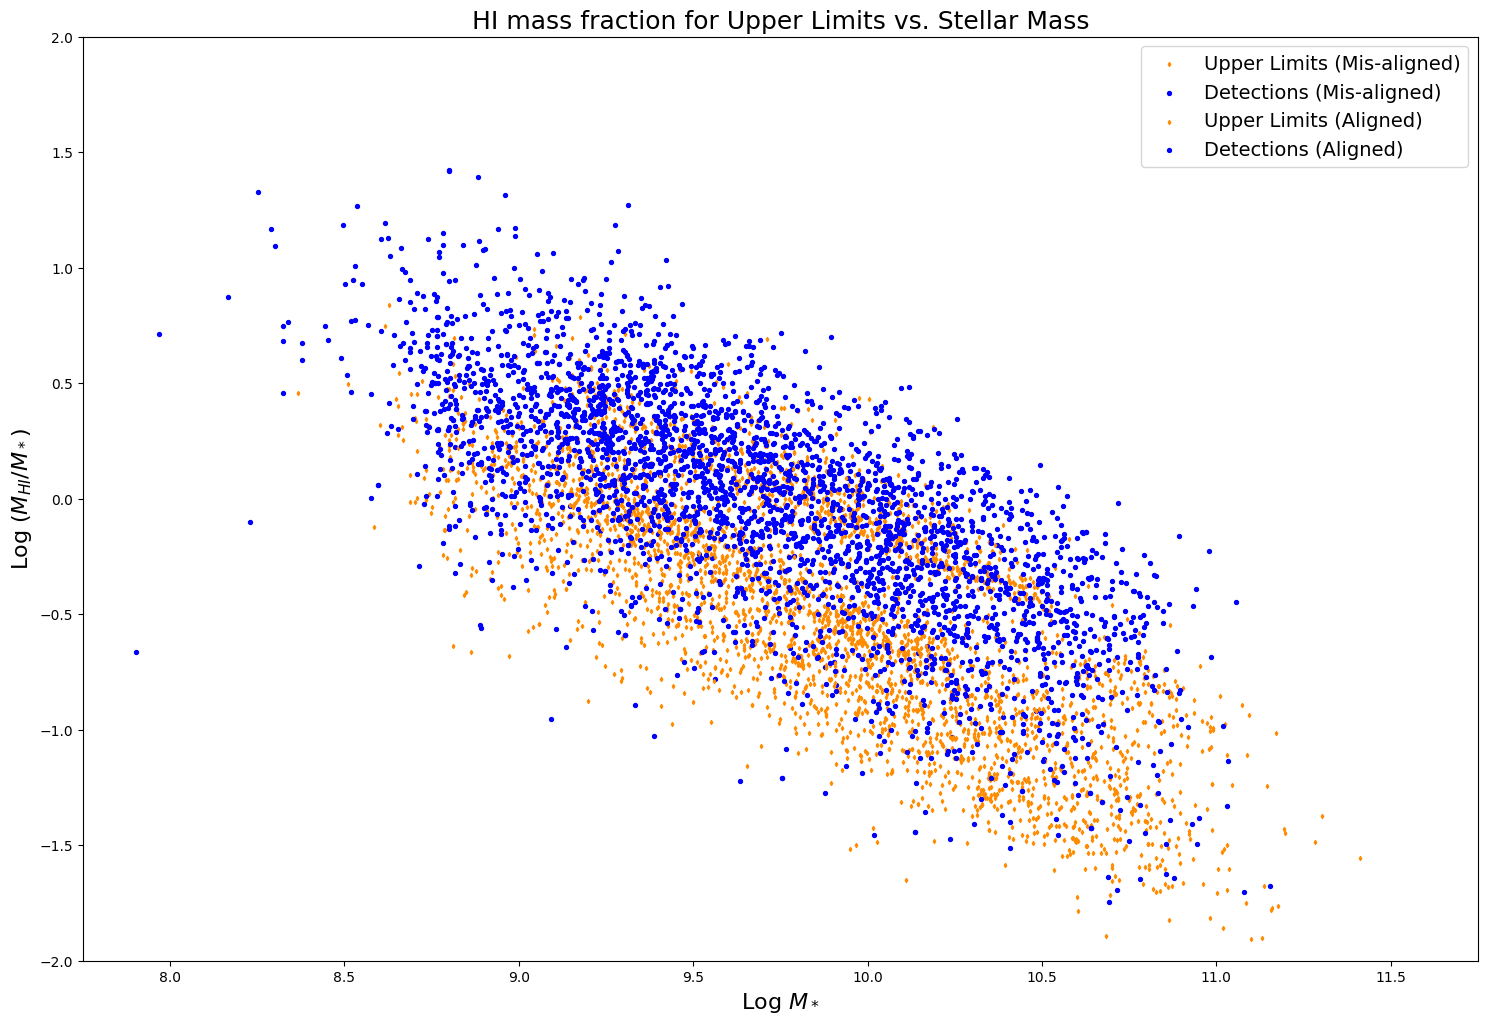

In [28]:
plt.figure(figsize=(18, 12));
plt.scatter(MALimStel, MALimFrac, label = 'Upper Limits (Mis-aligned)', s=4, marker='d', color='darkorange');
plt.scatter(MADetectionStel, MADetectionFrac, label = 'Detections (Mis-aligned)', s=8, color='blue')
plt.scatter(WALimStel, WALimFrac, label = 'Upper Limits (Aligned)', s=4, marker='d', color='darkorange')
plt.scatter(WADetectionStel, WADetectionFrac, label = 'Detections (Aligned)', s=8, color='blue')
plt.xlim(7.75, 11.75);
plt.ylim(-2, 2);
plt.legend(fontsize=14);
plt.xlabel('Log $M_*$', fontsize=16)
plt.ylabel('Log $(M_{HI}/M_*)$', fontsize=16);
plt.title('HI mass fraction for Upper Limits vs. Stellar Mass', fontsize=18);
# plt.savefig('detectAndLim_with_alignedAndMA.png');

Using David Stark's survival analysis code, which wraps R statistical code for Python use, we can create a linear fits for the aligned galaxies (now performing statistical methods on this set which includes both detections and upper limits), and misaligned galaxies (similarly):

**Caution**: This cell takes almost 6 minutes to run, so if the data has not changed, refer to next cell

In [97]:
'''
alignedComboMStars = np.ndarray(shape = len(alignedMStars)).astype(float)
alignedComboMFrac = np.ndarray(shape = len(alignedMFrac)).astype(float)
MAComboMStars = np.ndarray(shape = len(MAMStars)).astype(float)
MAComboMFrac = np.ndarray(shape = len(MAMFrac)).astype(float)

AlignedLims = np.ndarray(shape = len(alignedMStars)).astype(bool);
MALims = np.ndarray(shape = len(MAMStars)).astype(bool);

alignedGalInc = 0
MAGalInc = 0

alignedInc = 0
MAInc = 0

for gal in dataTable:
    if gal['LOGMSTARS'] > 0 and max(gal['LOGMHI'], gal['LOGHILIM200KMS']) > 0 and gal['plateifu_2'] == '': # the misaligned galaxies will have values for this column, which was taken from the fits image of just misaliged galaxies, while the aligned galaxies will not
        alignedComboMStars[alignedGalInc] = gal['LOGMSTARS']
        alignedComboMFrac[alignedGalInc] = max(gal['LOGMHI'], gal['LOGHILIM200KMS']) - gal['LOGMSTARS']
        if gal['LOGHILIM200KMS'] > 0: # If an upper limit
            AlignedLims[alignedInc] = True
        else:
            AlignedLims[alignedInc] = False
        alignedGalInc += 1
        alignedInc += 1
    if gal['LOGMSTARS'] > 0 and max(gal['LOGMHI'], gal['LOGHILIM200KMS']) > 0 and gal['plateifu_2'] != '':
        MAComboMStars[MAGalInc] = gal['LOGMSTARS']
        MAComboMFrac[MAGalInc] = max(gal['LOGMHI'], gal['LOGHILIM200KMS']) - gal['LOGMSTARS']
        if gal['LOGHILIM200KMS'] > 0:
            MALims[MAInc] = True
        else:
            MALims[MAInc] = False
        MAGalInc += 1
        MAInc += 1

AlignedOut = ats_fit(alignedComboMStars, alignedComboMFrac, AlignedLims, fmt='(I4, 2F10.3)');
MAOut = ats_fit(MAComboMStars, MAComboMFrac, MALims, fmt='(I4, 2F10.3)');


np.save('Data/alignedComboMStars.npy', alignedComboMStars)
np.save('Data/MAComboMStars.npy', MAComboMStars)
np.save('Data/alignedComboMFrac.npy', alignedComboMFrac)
np.save('Data/MAComboMFrac.npy', MAComboMFrac)
np.save('Data/AlignedLims.npy', AlignedLims)
np.save('Data/MALims.npy', MALims)
np.save('Data/alignedOut.npy', AlignedOut)
np.save('Data/MAOut.npy', MAOut)
'''

In [98]:
alignedComboMStars = np.load('Data/alignedComboMStars.npy', allow_pickle=True)
MAComboMStars = np.load('Data/MAComboMStars.npy', allow_pickle=True)
alignedComboMFrac = np.load('Data/alignedComboMFrac.npy', allow_pickle=True)
MAComboMFrac = np.load('Data/MAComboMFrac.npy', allow_pickle=True)
AlignedOut = np.load('Data/alignedOut.npy', allow_pickle=True)
MAOut = np.load('Data/MAOut.npy', allow_pickle=True)
AlignedLims = np.load('Data/AlignedLims.npy', allow_pickle=True)
MALims = np.load('Data/MALims.npy', allow_pickle=True)

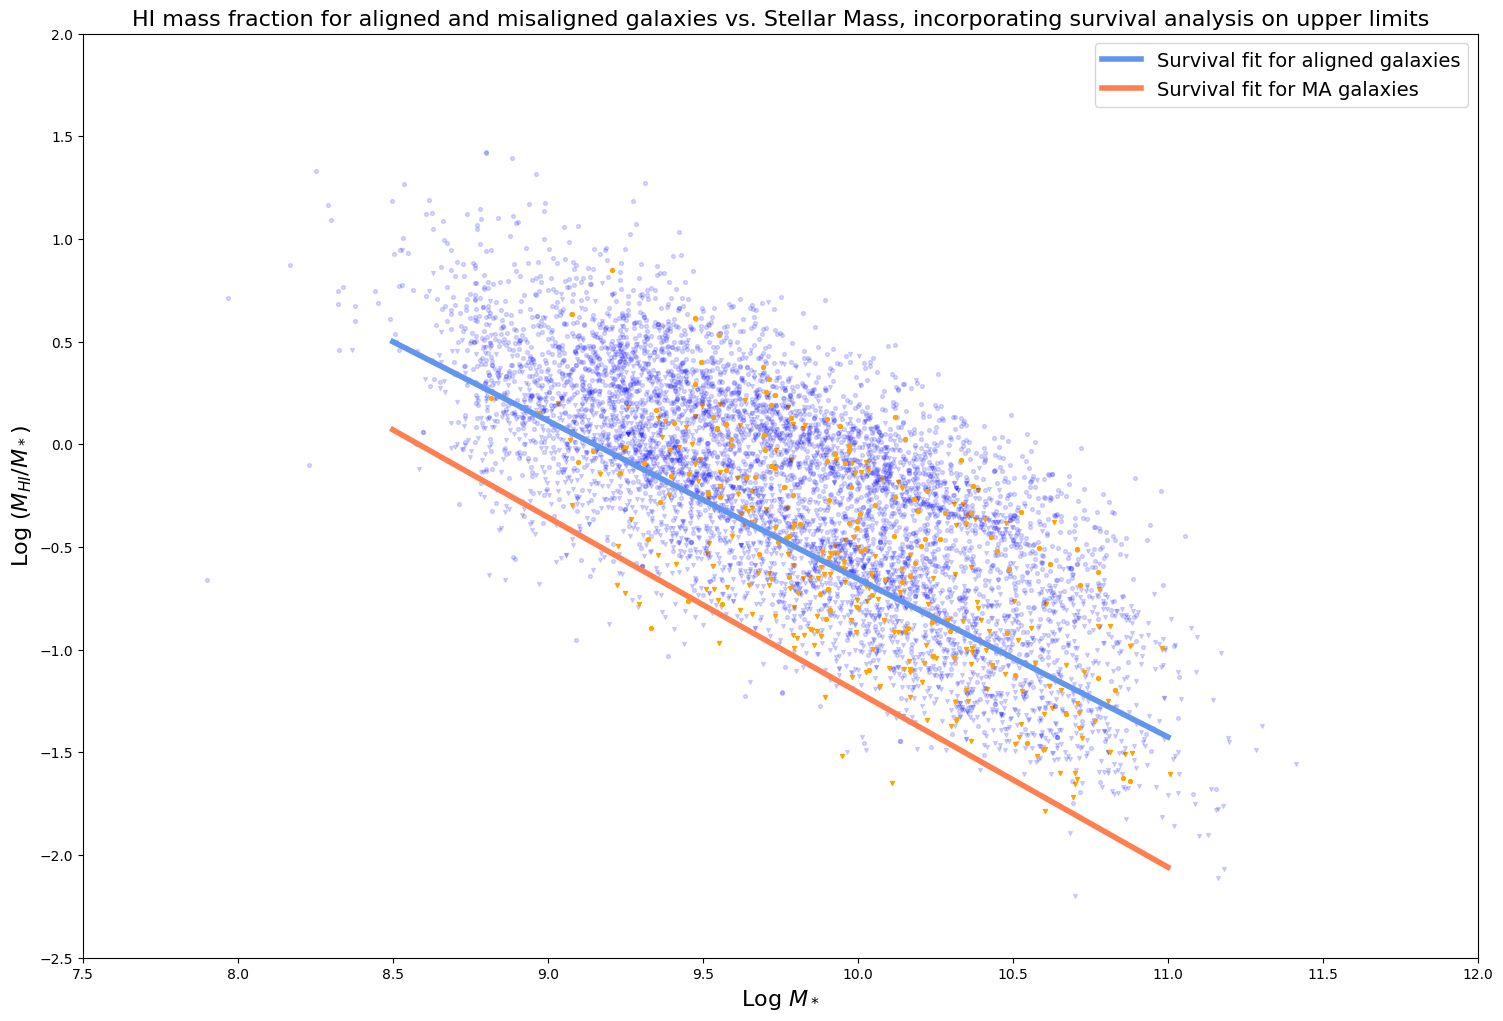

In [99]:
fig = plt.figure(figsize=(18, 12));

AlignedLimCol = 'blue'
AlignedDetCol = 'blue'
MALimCol = 'orange'
MADetCol = 'orange'

AlignedFitCol = 'cornflowerblue'
MAFitCol = 'coral'

# Upper limits:
plt.scatter(alignedComboMStars[AlignedLims], alignedComboMFrac[AlignedLims], s = 8, marker='v', color = AlignedLimCol, alpha = 0.15);
plt.scatter(MAComboMStars[MALims], MAComboMFrac[MALims], marker='v', s = 8, color = MALimCol);

# Detections:
plt.scatter(alignedComboMStars[~AlignedLims], alignedComboMFrac[~AlignedLims], s = 8, color = AlignedDetCol, alpha = 0.15);
plt.scatter(MAComboMStars[~MALims], MAComboMFrac[~MALims], s = 8, color = MADetCol);

pts = [8.5, 11]
plt.plot(pts, [(pts[0] * AlignedOut.item(0)['slope']) + AlignedOut.item(0)['intercept'], (pts[1] * AlignedOut.item(0)['slope']) + AlignedOut.item(0)['intercept']], color = AlignedFitCol, lw = 4, label = 'Survival fit for aligned galaxies');
plt.plot(pts, [(pts[0] * MAOut.item(0)['slope']) + MAOut.item(0)['intercept'], (pts[1] * MAOut.item(0)['slope']) + MAOut.item(0)['intercept']], color = MAFitCol, lw = 4, label = 'Survival fit for MA galaxies');

plt.legend(fontsize=14);
plt.xlim(7.5, 12)
plt.ylim(-2.5, 2)
plt.xlabel('Log $M_*$', fontsize=16)
plt.ylabel('Log $(M_{HI}/M_*)$', fontsize=16);
plt.title('HI mass fraction for aligned and misaligned galaxies vs. Stellar Mass, incorporating survival analysis on upper limits', fontsize=16);

In [100]:
print(10**(-1 * ((9.5 * AlignedOut.item(0)['slope'] + AlignedOut.item(0)['intercept']) - (9.5 * MAOut.item(0)['slope'] + MAOut.item(0)['intercept']))))

[0.30818461]


This data provides an even more shocking result, as by this method we conlude that the misaligned galaxies trend at only 30% of the expected HI mass expected at a given stellar mass (based on the difference between the values of the lines at $M_*$ = 9.5 $M_{Sun}$).

In [101]:
'''
# Upper limits:
plt.scatter(alignedComboMStars[AlignedLims], alignedComboMFrac[AlignedLims], s = 8, marker='v', color = AlignedLimCol, alpha = 0.15);
plt.scatter(MAComboMStars[MALims], MAComboMFrac[MALims], marker='v', s = 8, color = MALimCol);

# Detections:
plt.scatter(alignedComboMStars[~AlignedLims], alignedComboMFrac[~AlignedLims], s = 8, color = AlignedDetCol, alpha = 0.15);
plt.scatter(MAComboMStars[~MALims], MAComboMFrac[~MALims], s = 8, color = MADetCol);
'''
print('Aligned detection count: ', len(alignedComboMStars[~AlignedLims]))
print('Aligned upper limit count: ', len(alignedComboMStars[AlignedLims]))

print('\nMA detection count: ', len(MAComboMStars[~MALims]))
print('MA upper limit count: ', len(MAComboMStars[MALims]))

Aligned detection count:  3173
Aligned upper limit count:  3289

MA detection count:  110
MA upper limit count:  237


Unfortunately, we see that these sets are not <50% detections, so this survival anlysis method will not necessarily provide us with reasonable or accurate results. Still, there are other statistical methods we can apply to this data to account for the presence of upper limits.

First, however, we can investigate if we can derive useful data for this survival analysis method for smaller selections of stellar mass. That is, if the upper limits skew towards higher stellar mass galaxies, then we can draw conclusions about the amount of expected HI found in misaligned galaxies within a more restricted (lower) stellar mass range.

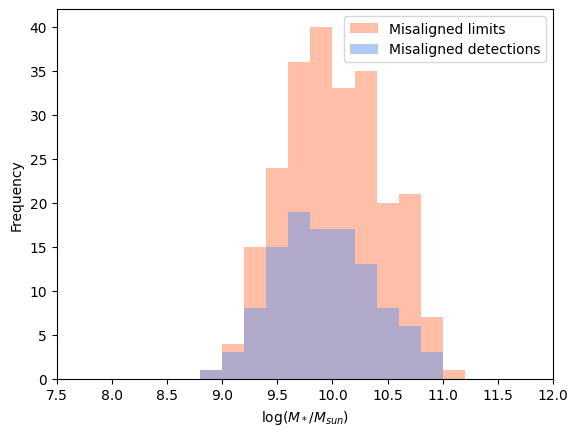

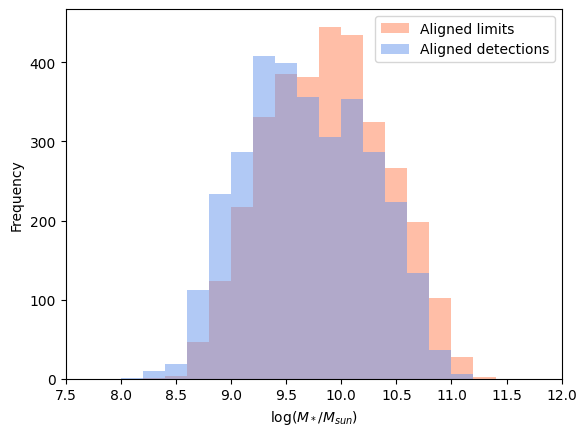

In [102]:
'''
Data:
Aligned upper limits: alignedComboMStars[AlignedLims]
Aligned detections: alignedComboMStars[~AlignedLims]

MA upper limits: MAComboMStars[MALims]
MA detections: MAComboMStars[~MALims]
'''

Bins = np.arange(8, 11.5, 0.2)

# Co-plotted histogram for frequency of misaligned gal detections vs. stellar mass and frequency of misaligned upper limits vs. stellar mass
plt.hist(MAComboMStars[MALims], alpha = 0.5, label = 'Misaligned limits', bins = Bins, color = 'coral')
plt.hist(MAComboMStars[~MALims], alpha = 0.5, label = 'Misaligned detections', bins = Bins, color = 'cornflowerblue')
plt.legend()
plt.xlim(7.5, 12)
plt.ylabel('Frequency')
plt.xlabel('log($M_*$/$M_{sun}$)')
plt.show()

# and co-plotted histogram for frequency of aligned detections vs. stellar mass and frequency of aligned upper limits vs stellar mass
plt.hist(alignedComboMStars[AlignedLims], alpha = 0.5, label = 'Aligned limits', bins = Bins, color = 'coral')
plt.hist(alignedComboMStars[~AlignedLims], alpha = 0.5, label = 'Aligned detections', bins = Bins, color = 'cornflowerblue')
plt.legend()
plt.xlim(7.5, 12)
plt.ylabel('Frequency')
plt.xlabel('log($M_*$/$M_{sun}$)')
plt.show()